# Sentinel-1 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

## Background

The [Sentinel-1](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) mission is composed of a constellation of two Synthetic Aperture Radar (SAR) satellites, Sentinel-1A and Sentinel-1B, sharing the same orbital plane. Sentinel-1 provides dual polarisation capability, very short revisit times, and rapid product delivery. The mission currently collects data every 12 days over Africa at a spatial resolution of approximately 20m. Sentinel-1A was launched on 3 April 2014 and Sentinel-1B followed on 25 April 2016. Two other spacecraft (Sentinel-1C and Sentinel-1D) are planned to replace the first two satellites at the end of their operational lifespan. For more information on the Sentinel-1 platforms and applications, check out the [European Space Agency](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-1) website.

SAR data has the advantage of operating at wavelengths not impeded by cloud cover and can acquire data over a site during the day or night. The Sentinel-1 mission is the European Radar Observatory for the Copernicus joint initiative of the European Commission (EC) and the European Space Agency (ESA) that can offer reliable and repeated wide area monitoring with its SAR instrument.

Radar backscatter measures the amount of microwave radiation reflected back to the centre from the ground surface. This measurement is sensitive to surface roughness, moisture content, and viewing geometry. DEAfrica provides Sentinel-1 backscatter as Radiometric Terrain Corrected (RTC) gamma-0 (γ0) where variation due to changing observation geometries has been mitigated.

DE Africa provides Sentinel-1 data acquired in Interferometric Wide Swath (IW) mode and with dual polarisation (VV and VH). The dual polarisation backscatter timeseries can be used in applications for forests, agriculture, wetlands, and land cover classification. SAR's ability to see through clouds makes it critical for mapping and monitoring land cover changes in the wet tropics. 

DEAfrica Sentinel-1 backscatter is processed to be compliant with the [CEOS Analysis Ready Data for Land (CARD4L)](https://ceos.org/ard/) specification. More technical information can be found in the [DE Africa User Guide](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-1_specs.html).


## Description

In this notebook we will load sentinel-1 Radiometric Terrain Corrected (RTC) SAR backscatter data. 

Topics covered include:
1. Inspecting the Sentinel-1 product and measurements available in the datacube
2. Using the native `dc.load()` function to load in Sentinel-1 data
3. Using the `load_ard` wrapper function to load masked Sentinel-1 data

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline
import datacube
import sys
import math 
import numpy as np
import matplotlib.pyplot as plt
from deafrica_tools.plotting import rgb 
from deafrica_tools.plotting import display_map
from deafrica_tools.datahandling import load_ard

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_1")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's SAR products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('radar')]

,name,description,license,default_crs,default_resolution
name,,,,,
s1_rtc,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,CC-BY-4.0,None,None


In [4]:
product = "s1_rtc"

### List measurements

We can further inspect the data available for each SAR product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
vv,vv,float32,1,NaN,[VV],NaN
vh,vh,float32,1,NaN,[VH],NaN
angle,angle,uint8,1,255.0,"[ANGLE, local_incidence_angle]",NaN
area,area,float32,1,NaN,"[AREA, normalised_scattering_area]",NaN
mask,mask,uint8,1,0.0,[MASK],"{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val..."


The Sentinel-1 product has five measurements:
* Backscatter in two polarisations,`VV` and `VH`. The two letters correspond to the polarisations of the light sent and received by the satellite. *VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
* A data mask, with `0` for `no-data`, `1` for valid data, and `2` for in/near radar shadow.
* Scattering area, the normalization that has been calcuated using a digital elevation model and been applied to obtain radiometric terrain correction.
* Local incidence angle.

## Load Sentinel-1 dataset using `dc.load()`

Now that we know what products and measurements are available for the product, we can load data from the datacube using `dc.load`.

In the example below, we will load Sentinel-1 for part of Ghana in 2020. 

We will load data from two polarisation bands,`VV` and `VH`, as well as the data mask (`'mask'`). The data is loaded in native EPSG:4326 coordinate reference system (CRS). It can be reprojected if `output_crs` and `resolution` are defined in the query.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [6]:
# Define the area of interest
latitude = 5.423
longitude = -0.464
buffer = 0.02
time = ('2020-12')

bands = ['vv','vh','mask']

We will also define an orbit direction for this query.
Sentinel-1 data are acquired in either `ascending` or `descending` passes.
Because the antenna is right-looking, data acquired in different orbit directions will have different viewing geometries.
This may lead to a difference in backscatter values, e.g. over bare or sparsely vegetated areas.

Most of the African continent is regularly covered by `ascending` passes.
For some locations, `descending` passes are also available.

For some applications, a user may wish to use data from both directions.
In this case, any potential bias should be evaluated first.

In [7]:
orbit_direction = 'ascending'

In [8]:
#add spatio-temporal extent to the query
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time':time,
    'sat_orbit_state': orbit_direction,
}

### Visualise the selected area 

In [9]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

In [10]:
# loading the data with the mask band included
ds_S1 = dc.load(product='s1_rtc',
                measurements=bands,
                group_by="solar_day",
                **query)

print(ds_S1)

<xarray.Dataset>
Dimensions:      (time: 5, latitude: 200, longitude: 200)
Coordinates:
  * time         (time) datetime64[ns] 2020-12-06T18:18:24.900676 ... 2020-12...
  * latitude     (latitude) float64 5.443 5.443 5.443 ... 5.404 5.403 5.403
  * longitude    (longitude) float64 -0.4839 -0.4837 -0.4835 ... -0.4443 -0.4441
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.07447 0.1258 ... 0.01145
    vh           (time, latitude, longitude) float32 0.01536 ... 0.0003317
    mask         (time, latitude, longitude) uint8 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


In [ ]:
# Plot all VV observations for the year, and apply data mask to exclude pixels in and near radar shadow
ds_S1.vv.where(ds_S1.mask==1).plot(cmap="Greys_r", robust=True, col="time", col_wrap=4);

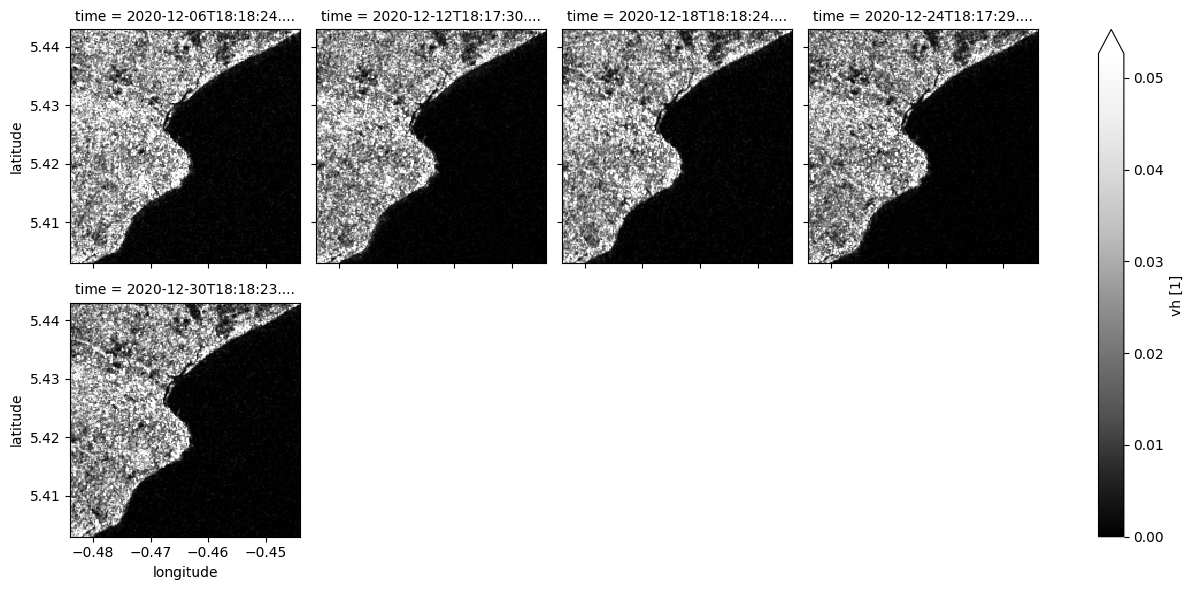

In [12]:
# Plot all VH observations for the year, and apply data mask to exclude pixels in and near radar shadow
ds_S1.vh.where(ds_S1.mask==1).plot(cmap="Greys_r", robust=True, col="time", col_wrap=4);

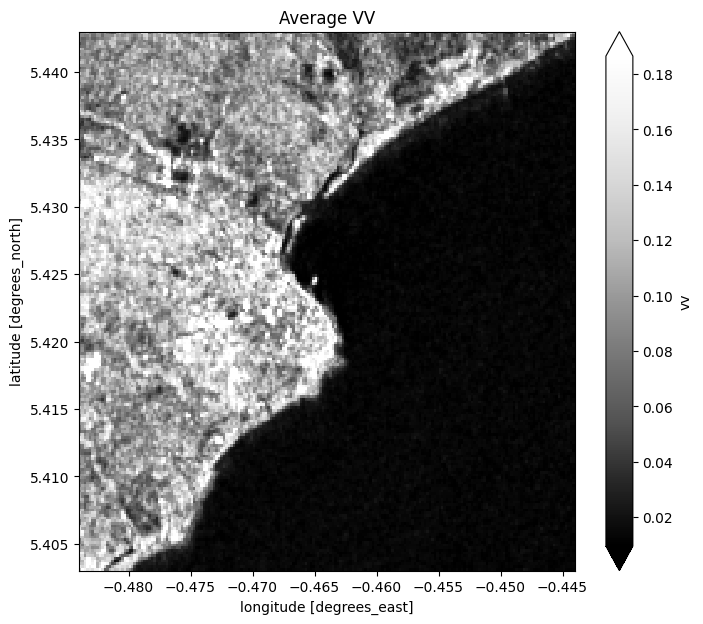

In [13]:
# Plot the average of all VV observations
mean_vv = ds_S1.vv.where(ds_S1.mask==1).mean(dim="time")

fig = plt.figure(figsize=(8, 7))
mean_vv.plot(cmap="Greys_r", robust=True)
plt.title("Average VV");

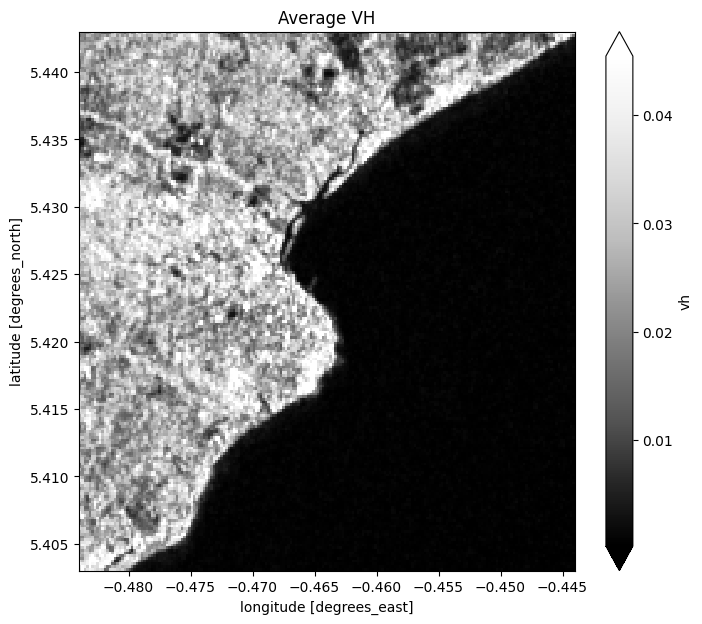

In [14]:
# Plot the average of all VH observations
mean_vh = ds_S1.vh.mean(dim="time")

fig = plt.figure(figsize=(8, 7))
mean_vh.plot(cmap="Greys_r", robust=True)
plt.title("Average VH");

Low backscatter is measured over water due to specular reflection. 

You may have noticed that the water in the individual *VV* and *VH* images isn't a consistent colour.
The distortion you're seeing is a type of noise known as speckle, which gives the images a grainy appearence.
Speckle noise can be reduced through filtering. Applying a speckle filter will reduce noise and improve our ability to distinguish water from land. 
If interested, you can find a technical introduction to speckle filtering [here](https://web.archive.org/web/20200618064515/https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf).

In [15]:
#creation of a new band (VH/VV=vhvv) for RGB display 
ds_S1['vhvv'] = ds_S1.vh.where(ds_S1.mask==1) / ds_S1.vv.where(ds_S1.mask==1)

In [ ]:
# Set the timesteps to visualise
timesteps = [0,1,3]

# Generate RGB plots at each timestep
rgb(ds_S1.where(ds_S1.mask==1), bands=['vh','vv','vhvv'], index=timesteps)

In the above false color composites, low backscatter is measured over water which appears black or dark blue. High backscatter is measured in urban areas which appear green. The salt and pepper a.k.a speckle noise over water is also visible. 

## Load Sentinel-1 using `load_ard`

This function will load images from Sentinel-1 and apply a pixel-quality mask.
The result is an analysis ready dataset free of shadow, and missing data.

You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [17]:
ds = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              group_by="solar_day",
              dtype='native',
              **query,
             )

print(ds)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 5 time steps
<xarray.Dataset>
Dimensions:      (time: 5, latitude: 200, longitude: 200)
Coordinates:
  * time         (time) datetime64[ns] 2020-12-06T18:18:24.900676 ... 2020-12...
  * latitude     (latitude) float64 5.443 5.443 5.443 ... 5.404 5.403 5.403
  * longitude    (longitude) float64 -0.4839 -0.4837 -0.4835 ... -0.4443 -0.4441
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.07447 0.1258 ... 0.01145
    vh           (time, latitude, longitude) float32 0.01536 ... 0.0003317
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


Below we plot the masked Sentinel-1 data with high quality.

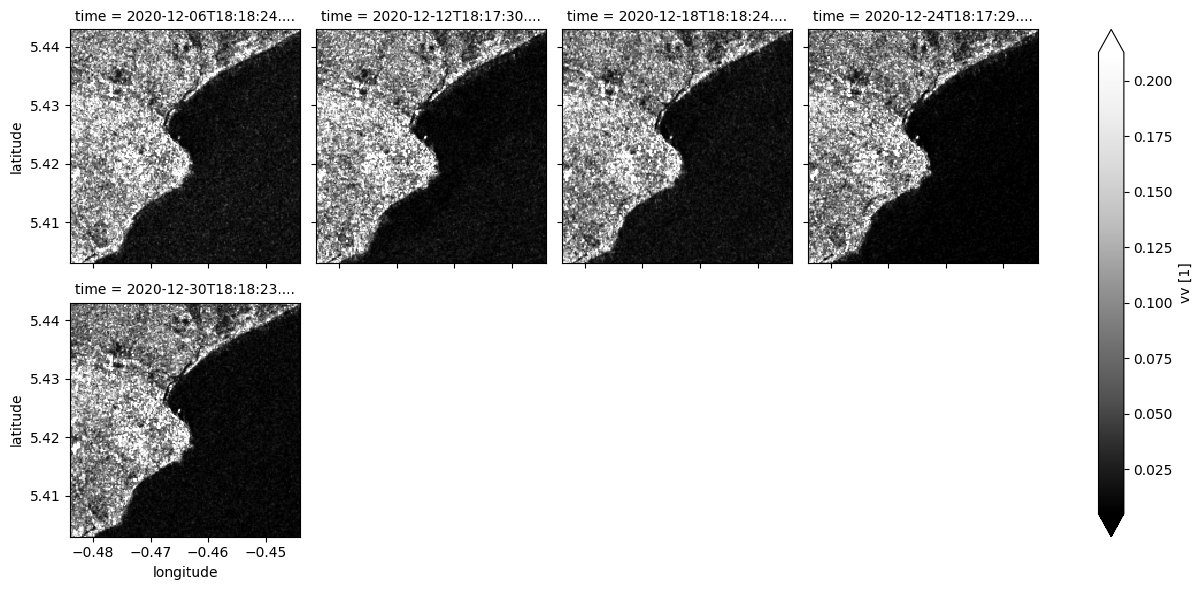

In [18]:
# Plot all VV observations for the year in which pixels in and near radar shadow have been excluded
ds.vv.plot(cmap="Greys_r", robust=True, col="time", col_wrap=4);

## Histogram Analysis for Sentinel-1 Dataset 

Histrograms below show bimodal distributions where low backscatter is measured over water.

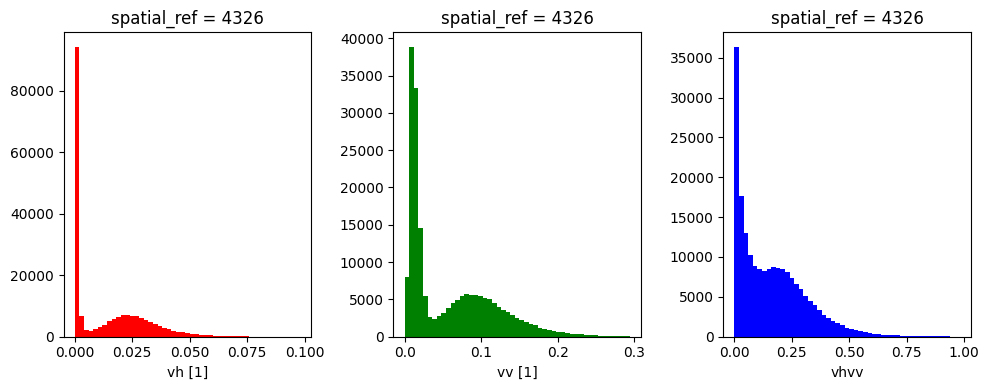

In [19]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ds_S1.vh.where(ds_S1.mask==1).plot.hist(ax=ax[0], bins=np.arange(0, 0.1, 0.002), facecolor='red')
ds_S1.vv.where(ds_S1.mask==1).plot.hist(ax=ax[1], bins=np.arange(0, 0.3, 0.006), facecolor='green')
ds_S1.vhvv.plot.hist(ax=ax[2], bins=np.arange(0, 1, 0.02), facecolor='blue')
plt.tight_layout()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-03-30'